In [1]:
from igraph import *
import numpy as np
import xnet
from collections import defaultdict
import glob
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
files = 'colabs/wbasic/*selected*pac5.xnet'

files = glob.glob(files)
files = sorted(files)

data = xnet.xnet2igraph('../data/citation_network_ge1990_pacs.xnet')

In [4]:
def get_set(labels,numeric):
    sets = {'0':set(),'1':set(),'2':set(),'3':set(),'4':set()}
    for n,l in zip(numeric,labels):
        sets[l].add(n)
    return sets

def map_set(sets1,sets2):
    idxs = dict()
    for k1,s1 in sets1.items():
        most_similar = '-1'
        value_similar = 1000000000
        for k2,s2 in sets2.items():
            v = 1 - len(s1&s2)/len(s1|s2)
            if v < value_similar:
                value_similar = v
                most_similar = k2
        idxs[k1] = most_similar
    return idxs

In [5]:
def get_vecs_cuts(bows):
    vecs = []
    cuts = [0]
    for bow in bows:
        for line in bow:
            v = np.asarray(ast.literal_eval(line))
            vecs.append(v)
        cuts.append(len(vecs))
    
    vecs = np.asarray(vecs)
    print(vecs.shape)
    return vecs,cuts

def maps_labels(labels,numeric):
    label_sets = []
    for n,l in zip(numeric,labels):
        label_sets.append(get_set(l,n))
    
    maps = [{'0':'0','1':'1','2':'2','3':'3','4':'4'}]
    for i in range(len(label_sets)-1):
        maps.append(map_set(label_sets[i],label_sets[i+1]))
    
    paths = []
    for l in ['0','1','2','3','4']:
        path = [maps[0][l]]
        for m in maps[1:]:
            path.append(m[path[-1]])
        paths.append(np.asarray(path))
    paths = np.asarray(paths)
    paths = paths.T
    
    return paths

def clustering(bows,labels,vecs,cuts):
    
    pca = PCA(n_components=3)
    pca.fit(vecs[cuts[0]:cuts[1]])
    
    colors = {'0':'red','1':'blue','2':'green','3':'purple','4':'orange'}
    
    year = 1990
    for i in range(len(cuts)-1):
#         path = paths[i]
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        
        bow_3d = pca.transform(vecs[cuts[i]:cuts[i+1]])
        
        cs = []
        for l in labels[i]:
# #             print(l,path)
#             bla = np.where(path==l)[0]
#             if len(bla) == 0:
#                 bla = l
#             else:
#                 bla = str(bla[0])
            cs.append(colors[l])
        
        ax.scatter(bow_3d[:,0],bow_3d[:,1],bow_3d[:,2],c=cs)
        plt.show()
        plt.savefig('test'+str(year+i)+'.pdf',format='pdf')
        

In [11]:
bows = []
labels = []
numeric_idxs = []
i = 0
for f in files:
    print(f)
    colab_net = xnet.xnet2igraph(f)
    bows.append(colab_net.vs['bow'])
    labels.append(colab_net.vs['pac_hier'])
    numeric_idxs.append(colab_net.vs['name'])
    print('hier',np.unique(colab_net.vs['pac_hier'],return_counts=True))
    print('kmeans',np.unique(colab_net.vs['pac_kmeans'],return_counts=True))
    i += 1

colabs/wbasic/colab_1990_1993.xnet_0.5_selected_wb_pac5.xnet
hier (array(['0', '1', '2', '3', '4'], dtype='<U1'), array([12339, 14666,   539,   187,  1010]))
kmeans (array(['0', '1', '2', '3', '4'], dtype='<U1'), array([26497,   310,   685,   843,   406]))
colabs/wbasic/colab_1991_1994.xnet_0.5_selected_wb_pac5.xnet
hier (array(['0', '1', '2', '3', '4'], dtype='<U1'), array([16264, 10022,  4426,   752,   177]))
kmeans (array(['0', '1', '2', '3', '4'], dtype='<U1'), array([  954,   393,   912, 28800,   582]))
colabs/wbasic/colab_1992_1995.xnet_0.5_selected_wb_pac5.xnet
hier (array(['0', '1', '2', '3', '4'], dtype='<U1'), array([ 4216, 14829,   206, 13591,  1591]))
kmeans (array(['0', '1', '2', '3', '4'], dtype='<U1'), array([31656,   713,   286,   961,   817]))
colabs/wbasic/colab_1993_1996.xnet_0.5_selected_wb_pac5.xnet
hier (array(['0', '1', '2', '3', '4'], dtype='<U1'), array([16515, 12540,   378,  5620,  1241]))
kmeans (array(['0', '1', '2', '3', '4'], dtype='<U1'), array([ 1137, 32

In [87]:
# paths = maps_labels(labels,numeric_idxs)

In [8]:
vecs,cuts = get_vecs_cuts(bows)

(1012742, 71)


<IPython.core.display.Javascript object>


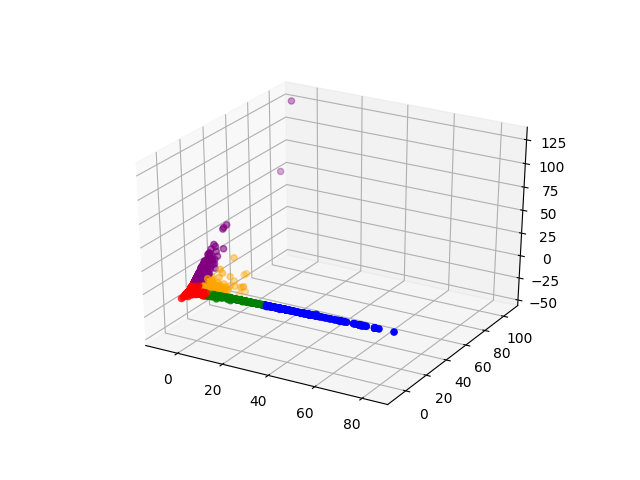

<IPython.core.display.Javascript object>


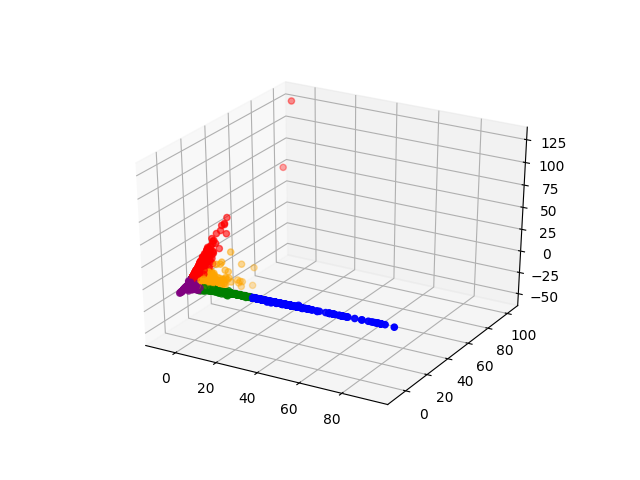

<IPython.core.display.Javascript object>


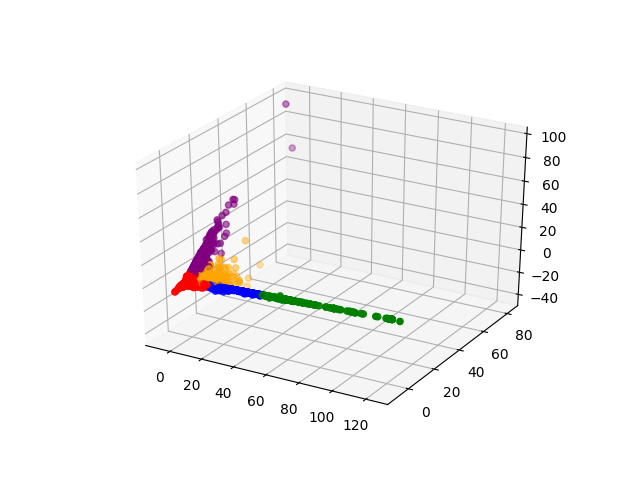

<IPython.core.display.Javascript object>


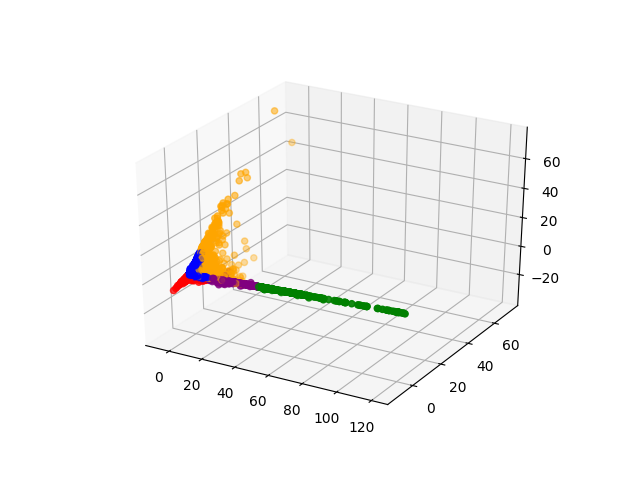

<IPython.core.display.Javascript object>


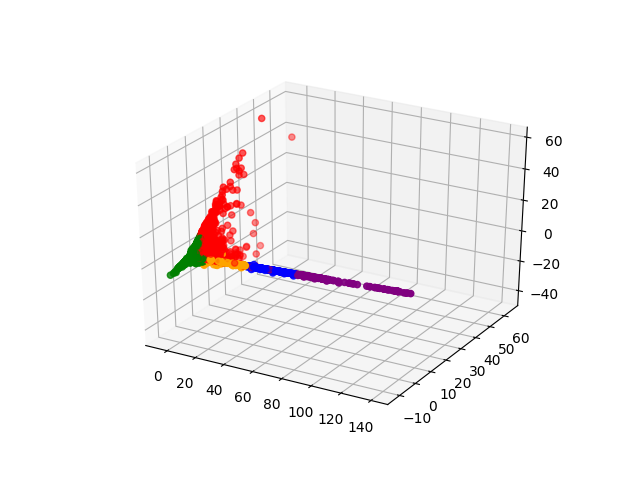

<IPython.core.display.Javascript object>


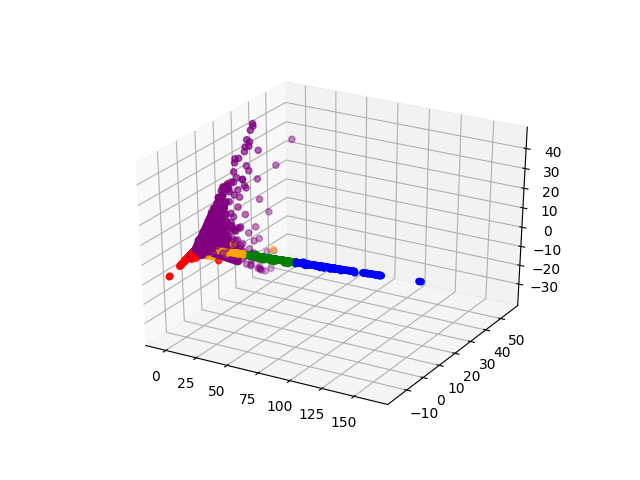

<IPython.core.display.Javascript object>


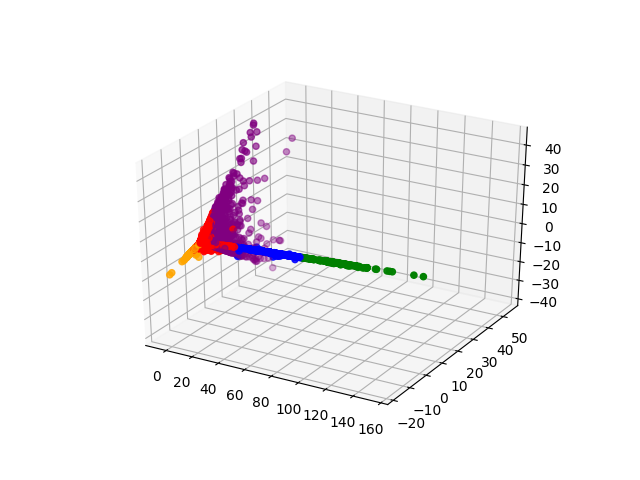

<IPython.core.display.Javascript object>


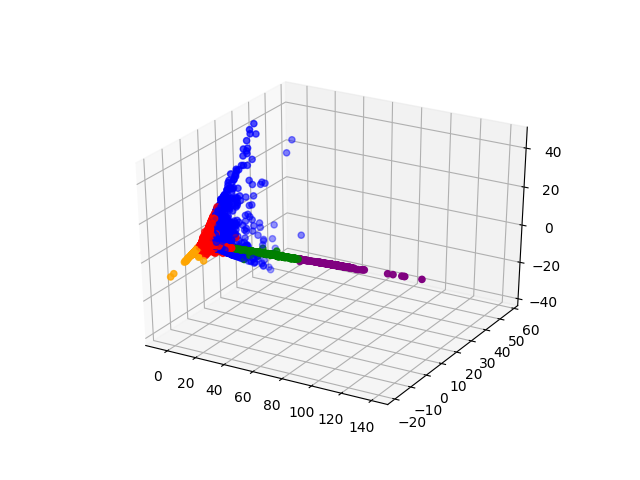

<IPython.core.display.Javascript object>


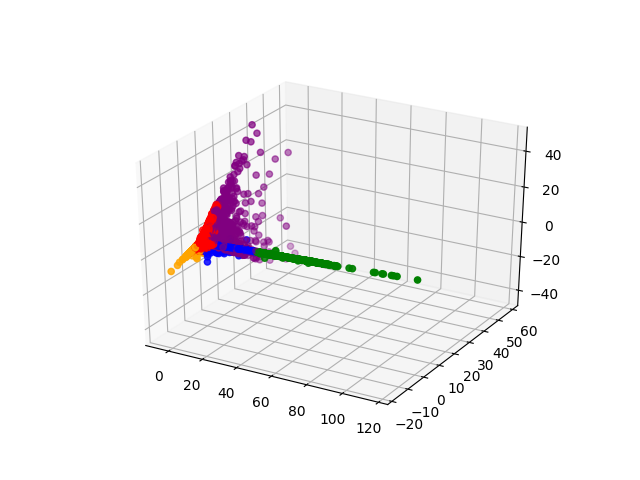

<IPython.core.display.Javascript object>


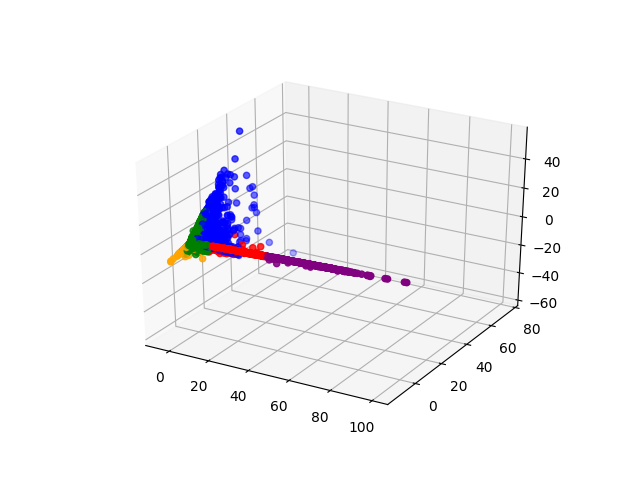

<IPython.core.display.Javascript object>


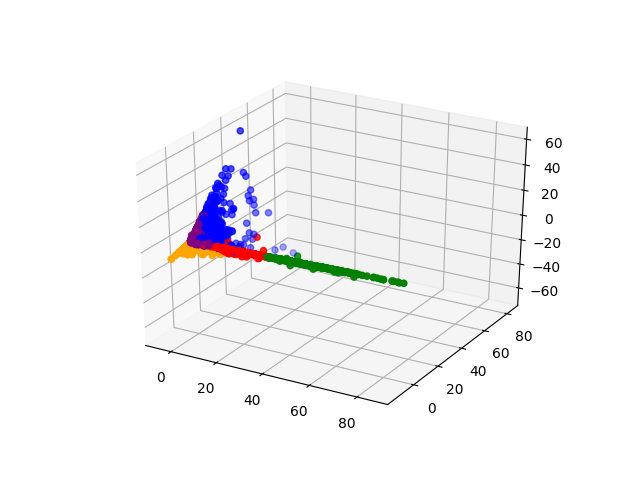

<IPython.core.display.Javascript object>


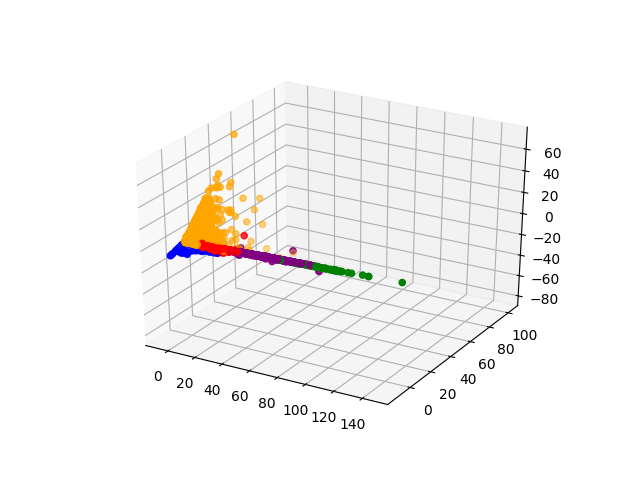

<IPython.core.display.Javascript object>


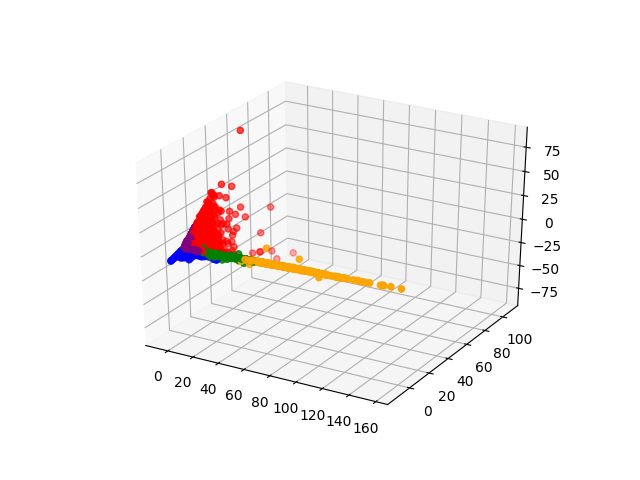

<IPython.core.display.Javascript object>


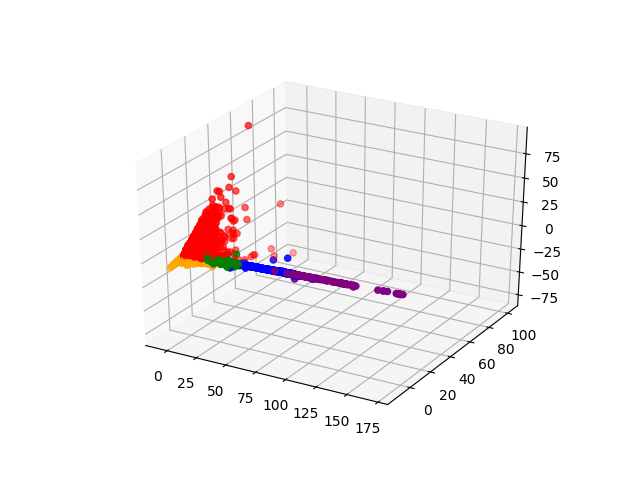

<IPython.core.display.Javascript object>


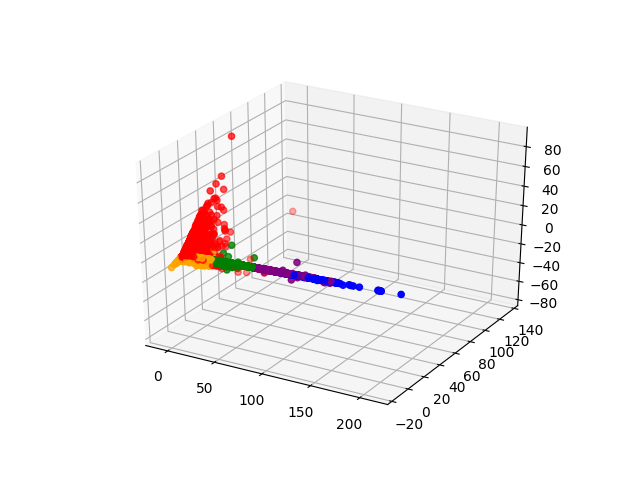

<IPython.core.display.Javascript object>


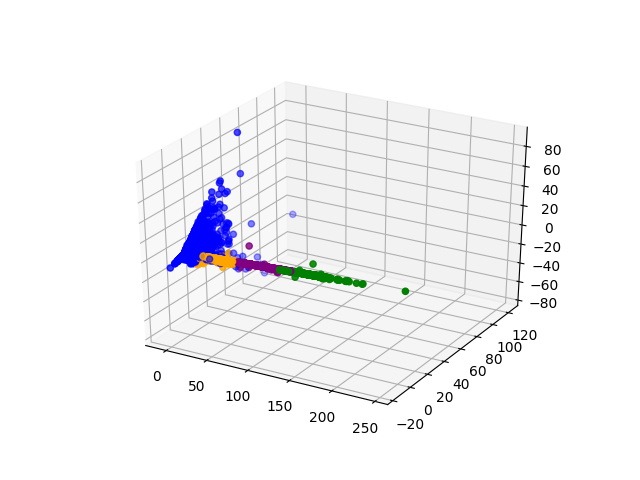

<IPython.core.display.Javascript object>


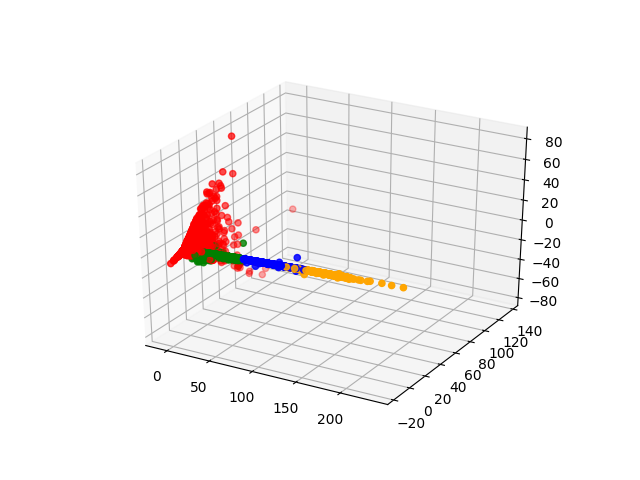

<IPython.core.display.Javascript object>


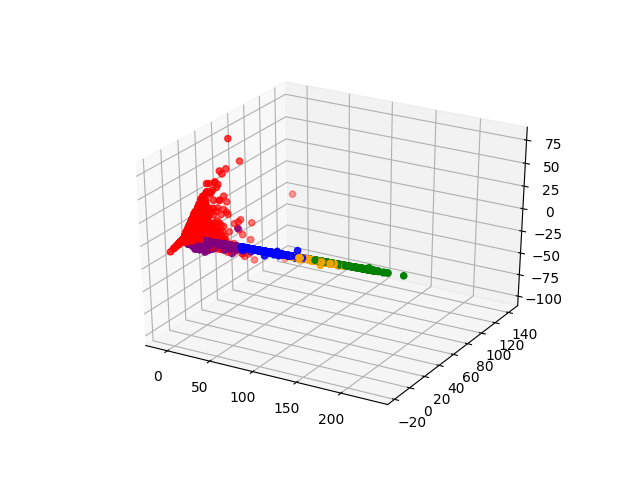

<IPython.core.display.Javascript object>


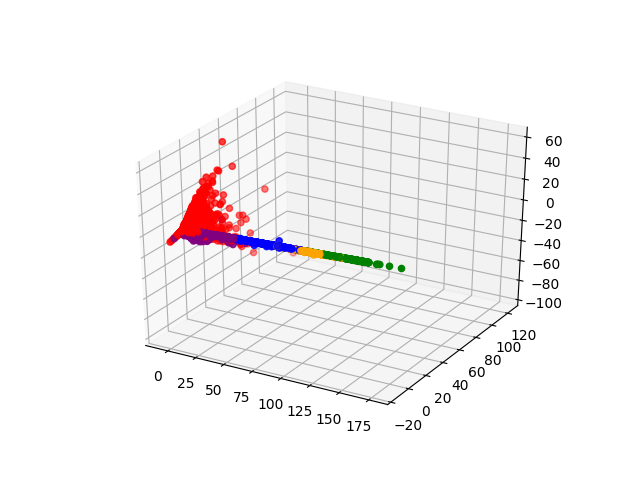

<IPython.core.display.Javascript object>


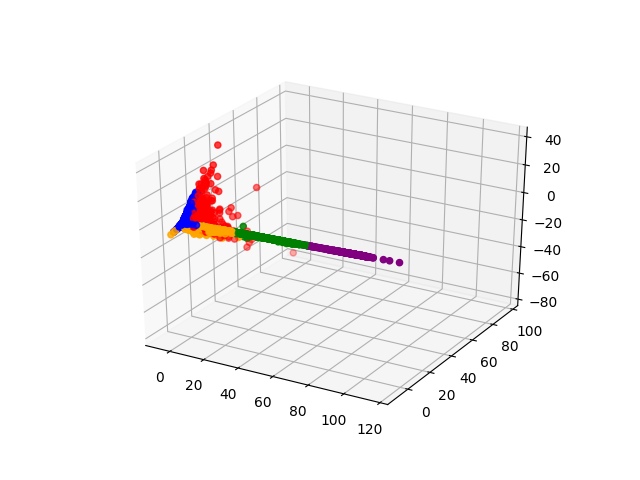

/usr/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


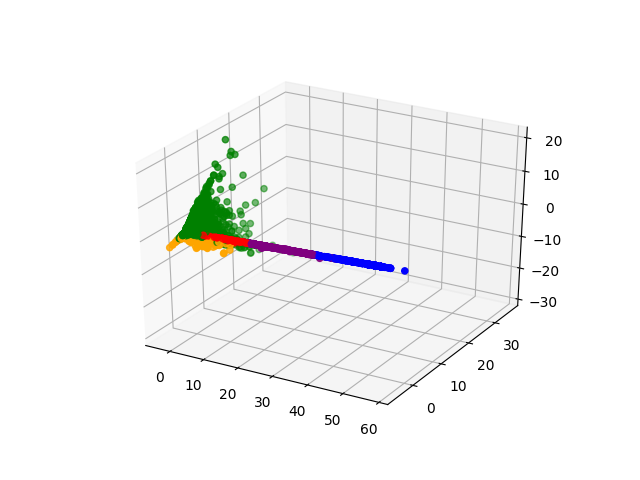

In [9]:
clustering(bows,labels,vecs,cuts)

In [21]:
def sparseVector(v): 
    return {n: val for n, val in enumerate(v) if val}

def sparse(bow,label):
    by_label = {'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[]}
    for b,l in zip(bow,label):
        by_label[l].append(b)
        
    for k,bow in by_label.items():
        print(k)
        for b in bow[:20]:
            print(sparseVector(b))

In [14]:
bows1 = []
for bow in bows:
    bow1 = []
    for b in bow:
        bow1.append(ast.literal_eval(b))
    bows1.append(bow1)

In [ ]:
for bow1 in bows1:
    clustering = AgglomerativeClustering(n_clusters=10,affinity='cosine',linkage='average')
    fited_clustering = clustering.fit(bow1)
    labels = fited_clustering.labels_
    labels = [str(l) for l in labels]
    sparse(bow1,labels)
#     colab_net.vs['pac_hier'] = labels
    print('hierarquico',np.unique(labels,return_counts=True))

    clustering = KMeans(n_clusters=10,random_state=0)
    fited_clustering = clustering.fit(bow1)
    labels = fited_clustering.labels_
    labels = [str(l) for l in labels]
    sparse(bow1,labels)
    print('kmeans',np.unique(labels,return_counts=True))

0
{4: 5, 36: 1, 39: 2, 70: 1}
{4: 1, 39: 1, 42: 1, 43: 5, 70: 1}
{36: 8, 70: 1}
{36: 3, 39: 4, 53: 1, 70: 1}
{38: 1, 70: 1}
{1: 1, 4: 1, 70: 1}
{36: 1, 39: 1, 49: 1, 50: 1, 70: 1}
{4: 1, 36: 4, 43: 3, 70: 1}
{43: 1, 44: 1, 46: 1, 52: 1, 70: 1}
{4: 1, 39: 5, 42: 1, 43: 1, 70: 1}
{36: 3, 43: 4, 54: 2, 70: 1}
{38: 1, 39: 2, 70: 1}
{36: 4, 43: 6, 52: 1, 70: 1}
{36: 2, 43: 2, 53: 1, 54: 2, 70: 1}
{22: 1, 43: 2, 70: 1}
{39: 2, 70: 1}
{37: 2, 39: 2, 44: 1, 45: 1, 48: 1, 70: 1}
{36: 3, 43: 2, 52: 1, 53: 1, 70: 1}
{25: 1, 30: 1, 36: 2, 40: 1, 43: 4, 47: 2, 48: 2, 49: 1, 53: 1, 70: 1}
{36: 1, 39: 1, 50: 1, 70: 1}
1
{48: 1, 70: 1}
{4: 1, 45: 1, 47: 12, 48: 4, 49: 5, 70: 1}
{47: 3, 70: 1}
{44: 1, 47: 1, 51: 2, 70: 1}
{36: 3, 39: 2, 41: 3, 44: 2, 47: 9, 48: 4, 49: 12, 53: 2, 70: 1}
{48: 2, 70: 1}
{25: 1, 41: 2, 44: 1, 47: 14, 48: 4, 49: 10, 51: 1, 70: 1}
{47: 1, 51: 2, 70: 1}
{44: 1, 45: 4, 47: 7, 48: 7, 70: 1}
{4: 1, 47: 4, 70: 1}
{45: 1, 47: 2, 70: 1}
{25: 1, 47: 3, 48: 1, 49: 3, 54: 1, 70: 1}
{4

0
{36: 9, 39: 2, 41: 3, 44: 2, 47: 11, 48: 4, 49: 18, 53: 4, 70: 1}
{36: 3, 39: 4, 53: 1, 70: 1}
{36: 1, 39: 1, 49: 1, 50: 1, 70: 1}
{4: 4, 36: 8, 70: 1}
{22: 2, 49: 2, 70: 1}
{4: 1, 36: 1, 43: 1, 70: 1}
{36: 4, 43: 6, 54: 2, 70: 1}
{36: 2, 43: 2, 53: 1, 54: 2, 70: 1}
{37: 2, 39: 2, 44: 1, 45: 1, 48: 1, 70: 1}
{36: 5, 43: 4, 49: 1, 52: 3, 53: 3, 70: 1}
{36: 1, 39: 1, 50: 1, 70: 1}
{36: 1, 37: 1, 51: 1, 70: 1}
{30: 1, 33: 1, 36: 1, 59: 1, 70: 1}
{4: 1, 48: 1, 70: 1}
{29: 2, 37: 3, 38: 6, 70: 1}
{25: 2, 36: 2, 43: 3, 70: 1}
{36: 1, 37: 1, 70: 1}
{38: 1, 39: 1, 40: 1, 70: 1}
{23: 1, 36: 1, 49: 1, 70: 1}
{4: 1, 28: 1, 36: 1, 39: 5, 51: 2, 54: 3, 70: 1}
1
{45: 1, 46: 2, 70: 1}
{44: 1, 70: 1}
{4: 1, 42: 1, 44: 3, 46: 3, 70: 1}
{20: 1, 22: 1, 28: 3, 36: 1, 40: 1, 51: 5, 53: 1, 70: 1}
{36: 1, 43: 2, 44: 1, 52: 3, 54: 1, 70: 1}
{45: 1, 51: 3, 70: 1}
{6: 1, 52: 1, 59: 1, 70: 1}
{28: 1, 51: 2, 70: 1}
{47: 1, 51: 2, 70: 1}
{46: 3, 51: 5, 70: 1}
{36: 1, 44: 5, 48: 1, 52: 2, 70: 1}
{36: 1, 44: 3, 51

0
{45: 3, 70: 1}
{45: 1, 46: 2, 70: 1}
{36: 4, 38: 2, 51: 2, 70: 1}
{4: 1, 42: 1, 44: 3, 46: 3, 70: 1}
{44: 1, 45: 1, 50: 1, 51: 1, 70: 1}
{45: 1, 51: 3, 70: 1}
{6: 1, 52: 1, 59: 1, 70: 1}
{39: 6, 70: 1}
{36: 1, 39: 2, 53: 1, 70: 1}
{46: 4, 51: 6, 70: 1}
{70: 1}
{36: 2, 44: 5, 45: 1, 46: 1, 48: 1, 52: 2, 70: 1}
{44: 2, 45: 2, 70: 1}
{2: 1, 4: 6, 36: 9, 41: 2, 42: 2, 54: 2, 55: 2, 70: 1}
{4: 1, 39: 1, 54: 1, 70: 1}
{36: 1, 44: 3, 51: 3, 70: 1}
{22: 2, 49: 2, 70: 1}
{36: 1, 44: 2, 49: 1, 51: 2, 70: 1}
{45: 2, 46: 1, 70: 1}
{4: 1, 27: 1, 36: 1, 43: 4, 44: 1, 46: 1, 51: 1, 70: 1}
1
{21: 2, 70: 1}
{6: 1, 28: 2, 70: 1}
{22: 1, 70: 1}
{20: 1, 22: 1, 28: 3, 40: 1, 51: 5, 70: 1}
{21: 2, 28: 2, 70: 1}
{21: 1, 23: 2, 70: 1}
{23: 3, 70: 1}
{28: 8, 70: 1}
{28: 2, 46: 3, 51: 1, 56: 1, 70: 1}
{28: 2, 42: 1, 44: 3, 51: 5, 70: 1}
{9: 1, 10: 1, 13: 1, 19: 2, 23: 1, 66: 1, 70: 1}
{23: 8, 70: 1}
{2: 1, 21: 1, 22: 2, 23: 1, 28: 2, 70: 1}
{28: 2, 44: 2, 51: 2, 70: 1}
{28: 6, 70: 1}
{23: 1, 70: 1}
{22: 4, 23

0
{36: 1, 43: 1, 51: 2, 52: 1, 70: 1}
{28: 1, 36: 2, 54: 1, 70: 1}
{4: 1, 33: 3, 70: 1}
{36: 2, 43: 2, 52: 1, 54: 2, 70: 1}
{36: 1, 39: 2, 53: 1, 70: 1}
{36: 2, 44: 3, 45: 1, 46: 1, 48: 1, 52: 1, 70: 1}
{2: 1, 4: 7, 36: 8, 41: 3, 42: 5, 54: 3, 55: 3, 70: 1}
{4: 1, 39: 1, 54: 1, 70: 1}
{36: 1, 51: 1, 70: 1}
{4: 1, 33: 1, 36: 1, 70: 1}
{36: 3, 43: 5, 70: 1}
{1: 3, 4: 6, 54: 1, 59: 1, 70: 1}
{1: 1, 4: 1, 33: 1, 39: 1, 70: 1}
{4: 1, 43: 2, 70: 1}
{36: 2, 43: 2, 53: 1, 54: 2, 70: 1}
{22: 2, 36: 2, 43: 3, 49: 1, 52: 5, 53: 3, 54: 2, 70: 1}
{48: 1, 49: 1, 54: 1, 70: 1}
{36: 1, 43: 1, 70: 1}
{2: 2, 4: 5, 39: 1, 44: 1, 47: 3, 51: 1, 54: 3, 70: 1}
{36: 6, 39: 8, 44: 2, 47: 2, 48: 5, 70: 1}
1
{20: 1, 21: 1, 35: 2, 70: 1}
{6: 2, 35: 6, 70: 1}
{35: 3, 70: 1}
{33: 4, 35: 8, 70: 1}
{2: 11, 4: 13, 6: 2, 19: 16, 27: 15, 35: 1, 70: 1}
{35: 2, 70: 1}
{35: 4, 70: 1}
{35: 2, 70: 1}
{35: 3, 70: 1}
{28: 6, 35: 5, 51: 2, 70: 1}
{35: 6, 70: 1}
{21: 4, 28: 5, 35: 8, 70: 1}
{35: 3, 70: 1}
{2: 1, 4: 1, 9: 1, 34: 